In [1]:
import cudaq
import numpy as np
import time

#cudaq.set_target('tensornet')

@cudaq.kernel
def two_qubit_gate(angle:float, qubit_1: cudaq.qubit, qubit_2: cudaq.qubit):  # mode: str = "CNOT_decomposition"  [cudaq doesn't support string type]
    x.ctrl(qubit_1, qubit_2)
    rz(angle, qubit_2)
    x.ctrl(qubit_1, qubit_2)

@cudaq.kernel
def Trotter_circuit(N: int, k:int, angles_ry:np.ndarray, angles_u3:np.ndarray, angles_2q:np.ndarray):  #list[int]
    # This is the actual Trotter circuit. Here the circuit construction for Trotterized version of time evolution happens
    # k : Trotter repeat length

    qreg=cudaq.qvector(N)

    for i in range(N):
        ry(angles_ry[i], qreg[i])

    for _ in range(k-1):
        for i in range(N):
            u3(angles_u3[i*3], angles_u3[i*3+1], angles_u3[i*3+2], qreg[i])

        for i in range(N):
            for j in range(i + 1, N): 
                two_qubit_gate(angles_2q[i*N+j], qreg[i], qreg[j])

    for i in range(N):
        u3(angles_u3[i*3], angles_u3[i*3+1], angles_u3[i*3+2], qreg[i])


In [2]:
def dict_to_res(counts):
  for key, value in counts.items():
    if value == 1: 
        final_config = key

  res = [1.0 if s == '1' else -1.0 for s in final_config]
  
  return np.array(res)


In [10]:
import matplotlib.pyplot as plt

def main(N,sample_size):
  k = 24
  s = np.random.choice([1.,-1.],size=N)

  angles_u3 = np.random.uniform(0,2*np.pi,3*N)
  angles_2q = np.random.uniform(0,2*np.pi,(N,N))

  tm = time.time()
  time_list = []
  for _ in range(sample_size):
    angles_ry = np.pi*(s + 1)/2
    counts = cudaq.sample(Trotter_circuit, N, k, angles_ry, angles_u3, np.reshape(angles_2q,-1), shots_count=1)
    s = dict_to_res(counts)
    time_list.append(time.time() - tm)
    tm = time.time()

  plt.plot(time_list)
  print(np.sum(time_list))

27.042052030563354


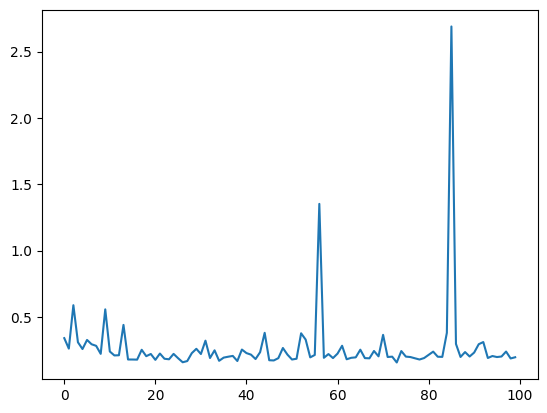

In [11]:
main(10,100)

In [ ]:
import argparse
if __name__ == "__main__":

    Trotter_circuit.compile()
    
    parser = argparse.ArgumentParser()
    parser.add_argument('N', type=int, help='The system size')
    parser.add_argument('--sample_size', type=int, default=100)

    args = parser.parse_args()
    tm=time.time()
    main(args.N, args.sample_size)
    print("Total Time: ", time.time()-tm)

usage: ipykernel_launcher.py [-h] [--sample_size SAMPLE_SIZE] [--seed SEED]
                             [--dir DIR]
                             N
ipykernel_launcher.py: error: the following arguments are required: N


SystemExit: 2

/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py:3587: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)
